# Model to predict diabetes progression based on patient BMI

The model is trained on scikit learn's toy dataset for diabetes progression. Based on the data recorded from each patient and the actual diabetes level recorded for the same patients after a year from baseline, the model can be used to predict and verify the model accuracy. We are going to split the data into training data, validation data and test data for the purpose.

In [1]:
# Import required libraries 

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

### 1. LOADING THE DATASET

The values in the dataset have been scaled by standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1) and mean centered. To understand the data better, we're going to plot and explore on non-scaled data by setting scaled=False.

In [2]:
diabetes_ds = datasets.load_diabetes(return_X_y=False, as_frame=False, scaled=False)
X = diabetes_ds.data[:, np.newaxis, 2]
y = diabetes_ds.target

The dataset consists records of 442 patients. 

The 'data' in the dataset consists of entries of the following columns -

1. age 
2. sex
3. bmi
4. bp
5. s1(tc) total serum cholesterol
6. s2 (ldl) low-density lipoproteins
7. s3(hdl) high-density lipoproteins
8. s4(tch) total cholesterol / HDL
9. s5(ltg) possibly log of serum triglycerides level
10. s6(glu) blood sugar level

The 'target' data has the record of diabetes progressed in the patients after a year.

In [3]:
patients_df = pd.DataFrame(diabetes_ds.data, columns=diabetes_ds.feature_names)
patients_df.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


In [4]:
target_df = pd.DataFrame(diabetes_ds.target)
target_df.head(5)

,0
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


### 2. FRAMING THE MODEL

The model we're going to run will have patient BMI in X axis and the predicted diabetes result in Y axis. The models will have only one feature for running polynomial regression, which is BMI. We are going to run polynomial regression of degree 0 to 5 and compare all 6 models to check which model performs the best. With the best model, we will manually verify accuracy. 

To do this, we will first perform analysis of the data by exploring statistics with histogram and correlation matrix.

### 3. EXPLORATORY DATA ANALYSIS

In [5]:
patients_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


From the description of the dataset, we can infer that the patients were between the age 19 and 79 and the BMI range lies between 18 and 42. So the data does not concentrate on a specific group of age group or sex or bmi. With the varying data source, we can train a good prediction model. The data already shows **s6** glucose level of patients where the maximum was only 124. So the data source is a group of people with normal glucose range in the beginning which makes it fit to predict the progression.

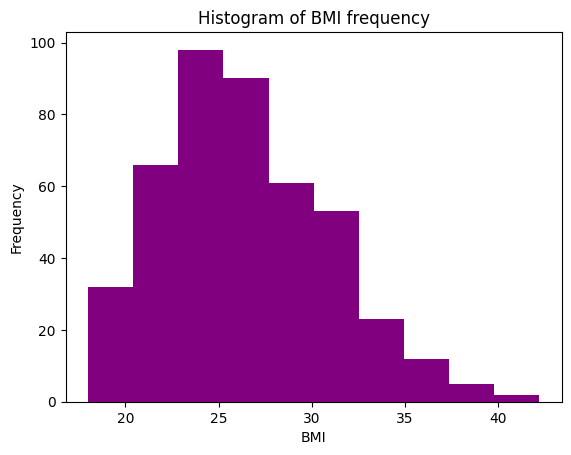

In [6]:
plt.hist(X, color="purple")
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI frequency')
plt.show()

According to the histogram that shows frequency of BMI in the given dataset, majority of the patients had BMI within the range of 21 to 32. Only above 50 people had BMI around 20. The number of people with BMI greater than 32 were collectively around 35.

In [7]:
correlation_matrix = patients_df.corr()
print(correlation_matrix)

          age       sex       bmi        bp        s1        s2        s3   
age  1.000000  0.173737  0.185085  0.335428  0.260061  0.219243 -0.075181  \
sex  0.173737  1.000000  0.088161  0.241010  0.035277  0.142637 -0.379090   
bmi  0.185085  0.088161  1.000000  0.395411  0.249777  0.261170 -0.366811   
bp   0.335428  0.241010  0.395411  1.000000  0.242464  0.185548 -0.178762   
s1   0.260061  0.035277  0.249777  0.242464  1.000000  0.896663  0.051519   
s2   0.219243  0.142637  0.261170  0.185548  0.896663  1.000000 -0.196455   
s3  -0.075181 -0.379090 -0.366811 -0.178762  0.051519 -0.196455  1.000000   
s4   0.203841  0.332115  0.413807  0.257650  0.542207  0.659817 -0.738493   
s5   0.270774  0.149916  0.446157  0.393480  0.515503  0.318357 -0.398577   
s6   0.301731  0.208133  0.388680  0.390430  0.325717  0.290600 -0.273697   

           s4        s5        s6  
age  0.203841  0.270774  0.301731  
sex  0.332115  0.149916  0.208133  
bmi  0.413807  0.446157  0.388680  
bp   0.2

The correlation matrix shows the relationship of each column with other columns in the dataset. The related columns involved in this prediction model is the bmi and glucose level. Even though the value is small, it shows a positive correlation of 0.388680. Which means as bmi goes higher, elevated glucose level is observed.

### 4. DATA CLEANING

If any constraint was to be considered, ex: gender of the patient, age group, we could do data cleaning here. Since there isn't any invalid entries in the dataset and no missing values, there is no need for data cleaning.

### 5. SPLITTING OF TRAINING, VALIDATION AND TEST DATA

In [8]:
# Splitting using Scikit-learn model_selection module's train_test_split() function

# 30 % of the data used for validation+test and 70% is used for training
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)

# Within the 30%, 15% is used for validation and 50% is used for testing
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

### 6. POLYNOMIAL REGREESION (DEGREE 0 TO 5)

In [9]:
# Running for degree 0 to 5
degrees = [0, 1, 2, 3, 4, 5]

models = []
training_rsquares = []
training_maes = []
training_mapes = []
validation_rsquares = []
validation_maes = []
validation_mapes = []

For each degree, we will record the R^2 score, Mean Absolute Value (MAV), Mean Absolute Percentage Error (MAPE) of both training and validation dataset for comparison between the models.

In [10]:
for degree in degrees:
    model_features = PolynomialFeatures(degree=degree)
    train_poly = model_features.fit_transform(X_train)
    validation_poly = model_features.transform(X_val)
    model = LinearRegression()
    model.fit(train_poly, y_train)

    train_pred = model.predict(train_poly)
    validation_pred = model.predict(validation_poly)

    training_rsquares.append(r2_score(y_train, train_pred))
    training_maes.append(mean_absolute_error(y_train, train_pred))
    training_mapes.append(mean_absolute_percentage_error(y_train, train_pred))

    validation_rsquares.append(r2_score(y_val, validation_pred))
    validation_maes.append(mean_absolute_error(y_val, validation_pred))   
    validation_mapes.append(mean_absolute_percentage_error(y_val, validation_pred))
    
    models.append(model)    

### 7. MODEL COMPARISON

#### 7.1 REPORT THE RESULTS

In [11]:
results_df = pd.DataFrame({
    'Train R^2': training_rsquares,
    'Validation R^2': validation_rsquares,
    'Train MAE': training_maes,
    'Validation MAE': validation_maes,
    'Train MAPE': training_mapes,
    'Validation MAPE': validation_mapes
})

print(results_df)

   Train R^2  Validation R^2  Train MAE  Validation MAE  Train MAPE   
0   0.000000       -0.008055  66.713922       62.042954    0.637647  \
1   0.365765        0.302543  51.951199       48.270702    0.482628   
2   0.366837        0.296223  51.883089       48.273028    0.482172   
3   0.366840        0.297015  51.878337       48.235127    0.482086   
4   0.368665        0.263194  51.772629       48.367440    0.479762   
5   0.369675        0.297578  51.760799       47.348851    0.479192   

   Validation MAPE  
0         0.579577  
1         0.420456  
2         0.419024  
3         0.418775  
4         0.414836  
5         0.407376  


#### 7.2 CONCLUSION FROM THE RESULTS

The model with the best R^2 value for validation dataset is considered the best model.

In [12]:
# Find the degree of the best fit

best_degree = degrees[np.argmax(validation_rsquares)]
best_model = models[np.argmax(validation_rsquares)]

print(f"Best Model is of degree {best_degree} with R^2 {validation_rsquares[best_degree]}")

Best Model is of degree 1 with R^2 0.3025429471847284


##### 7.2.1 RUN TEST ON THE BEST MODEL

In [13]:
test_poly = PolynomialFeatures(degree=best_degree).fit_transform(X_test)
test_pred = best_model.predict(test_poly)
test_rsquare = r2_score(y_test, test_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)

print("Test R^2:", test_rsquare)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

Test R^2: 0.2605731984821167
Test MSE: 4198.449565925882
Test MAE: 52.880785447649295


##### 7.2.2 GRAPH OF TRAINING, VALIDATION AND TEST DATAPOINTS WITH BEST FIT

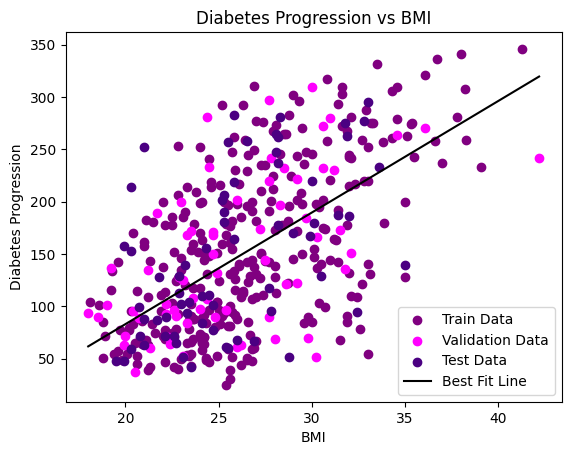

In [14]:
plt.scatter(X_train, y_train, color='purple', label='Train Data')
plt.scatter(X_val, y_val, color='magenta', label='Validation Data')
plt.scatter(X_test, y_test, color='indigo', label='Test Data')
plt.xlabel('BMI')
plt.ylabel('Diabetes Progression')
plt.title('Diabetes Progression vs BMI')
x_values = np.linspace(X.min(), X.max(), 100)
x_poly_values = PolynomialFeatures(degree=best_degree).fit_transform(x_values.reshape(-1, 1))
y_values = best_model.predict(x_poly_values)
plt.plot(x_values, y_values, color='black', label='Best Fit Line')
plt.legend()
plt.show()

##### 7.2.3 EQUATION OF THE MODEL

In [15]:
coefs = best_model.coef_
intercept = best_model.intercept_
equation = f"Diabetes Progression = {intercept:.2f}"
for i in range(1, best_degree + 1):
    equation += f" + {coefs[i]:.2f} * BMI^{i}"
print("Equation of the best model is:\n", equation)

Equation of the best model is:
 Diabetes Progression = -129.95 + 10.65 * BMI^1


Manually checking expedited diabetes progression value for BMI of 25

In [16]:
bmi_value = 23
check_poly = PolynomialFeatures(degree=best_degree).fit_transform(np.array([[bmi_value]]))
expected_progression = best_model.predict(check_poly)[0]
print("Expected diabetes progression for BMI 25:", expected_progression)

Expected diabetes progression for BMI 25: 115.07869203928132


From the target values, a BMI of 23 saw a diabetic progression around 135. Our model gives 115 which is a close prediction.

#### 7.3 TRAINABLE PARAMETERS USING _get_feature_names_out()_

In [17]:
for degree, model in zip(degrees, models):
    poly_features = PolynomialFeatures(degree=degree)
    train_poly = poly_features.fit_transform(X_train)
    feature_names = poly_features.get_feature_names_out(input_features=['BMI'])
    print(f"Degree {degree}: {train_poly.shape[1]} trainable parameters")
    print(f"Features: {feature_names}")

Degree 0: 1 trainable parameters
Features: ['1']
Degree 1: 2 trainable parameters
Features: ['1' 'BMI']
Degree 2: 3 trainable parameters
Features: ['1' 'BMI' 'BMI^2']
Degree 3: 4 trainable parameters
Features: ['1' 'BMI' 'BMI^2' 'BMI^3']
Degree 4: 5 trainable parameters
Features: ['1' 'BMI' 'BMI^2' 'BMI^3' 'BMI^4']
Degree 5: 6 trainable parameters
Features: ['1' 'BMI' 'BMI^2' 'BMI^3' 'BMI^4' 'BMI^5']


For each training degree, the maximum value of the exponential power will be equal to the degree as shown above. Ex: For degree 3 the feature parameters will be 1, BMI, BMI^2, BMI^3.